In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

## Limpieza

Somos el grupo 6, vamos a estar trabajando con Bahía Blanca - Cerri, que tiene el código 3

In [ ]:
#eph2004 = pd.read_stata('./input/Individual_t104.dta', preserve_dtypes= True)
#eph2024 = pd.read_excel('./input/usu_individual_T124.xlsx') # Ya lo guardé como csv, no tengo que cargarlo más como excel

In [ ]:
# Por algún motivo a alguien se le ocurrió poner "Menos de 1 año", lo fuerzo a que sea numérico y lleno los NAs con 0
#eph2004['ch06'] = pd.to_numeric(eph2004['ch06'], errors='coerce')
#eph2004['ch06'] = eph2004['ch06'].fillna(0)
#eph2004['ch06'] = eph2004['ch06'].apply(int)

In [ ]:
# Las columnas de la de 2024 están en mayúscula, las pongo en minúscula
#eph2024.columns = eph2024.columns.str.lower()

In [88]:
# Como el excel tarda demasiado en cargar, lo guardo como csv
#eph2024.to_csv('./input/usu_individual_T124.csv', encoding= 'utf-8', index= False)
#eph2004.to_csv('./input/usu_individual_t104.csv', encoding= 'utf-8', index= False)

Una vez que lo guardamos, comentamos el código porque ya no va a hacer falta

In [2]:
# Guardo el tipo de columna de las columnas que me interesan
tipos_columnas = {
    'componente': 'category',
    'aglomerado': 'category',
    'ch04': 'category', # Sexo
    'ch06': 'float64', # Edad
    'ch07': 'category', # Estado Civil
    'ch08': 'category', # Vinculacion con el jefe de hogar
    'nivel_ed': 'category', # Nivel educativo
    'estado': 'category', # Condición de actividad (ej: ocupado/inactivo)
    'cat_inac': 'category', # Categoría de inactividad (ej: jubilado)
    'ipcf': 'float64', # Ingreso per cápita familiar
	'pp09a_esp' : 'str', # Estas últimas dos me hacían saltar una advertencia, así que las aguregué para resolver el problema
	'pp09c_esp': 'str'
}

In [3]:
# Para que no me salte una advertencia, le especifico el tipo de la columnas que me interesan
eph2024 = pd.read_csv('./input/usu_individual_T124.csv', dtype = tipos_columnas)
eph2004 = pd.read_csv('./input/usu_individual_t104.csv', dtype = tipos_columnas, low_memory = False) # Me saltaba un warning para muchas columnas

### Bahía Blanca

In [4]:
bb_2004 = eph2004.loc[eph2004['aglomerado'] == 'Bahía Blanca - Cerri']
bb_2024 = eph2024.loc[eph2024['aglomerado'] == '3']

In [5]:
print(f'Shape Bahía Blanca 2004: {bb_2004.shape}')
print(f'Shape Bahía Blanca 2024: {bb_2024.shape}')

Shape Bahía Blanca 2004: (1156, 176)
Shape Bahía Blanca 2024: (1008, 177)


In [6]:
bb_2004 = bb_2004.loc[(bb_2004['ch06'] > 0) & (bb_2004['ipcf'] >= 0)]
bb_2024 = bb_2024.loc[(bb_2024['ch06'] > 0) & (bb_2024['ipcf'] >= 0)]

In [7]:
print(f'Shape Bahía Blanca 2004: {bb_2004.shape}')
print(f'Shape Bahía Blanca 2024: {bb_2024.shape}')

Shape Bahía Blanca 2004: (1142, 176)
Shape Bahía Blanca 2024: (998, 177)


In [8]:
# En 2024, la variable de sexo tiene valores 1 y 2, quiero ponerle el texto en lugar de los números
bb_2024['ch04'] = bb_2024['ch04'].cat.rename_categories({'1': "Varón", '2': "Mujer"})

### Composición mujeres-varones

In [9]:
bb_2004_counts = bb_2004['ch04'].value_counts(normalize=True) * 100
bb_2024_counts = bb_2024['ch04'].value_counts(normalize=True) * 100

# Calculo para cada año el procentaje de varones y el porcentaje de mujeres

In [ ]:
def composicion_bar(val_2004, val_2024, x_label):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    bars_2004 = axs[0].bar(val_2004.index, val_2004.values, color='skyblue')
    axs[0].set_title('Composición en 2004')
    axs[0].set_xlabel(x_label)
    axs[0].set_ylabel('Porcentaje')
    axs[0].set_ylim(0, 100)

    for bar, value in zip(bars_2004, val_2004.values):
        axs[0].text(bar.get_x() + bar.get_width() / 2, value + 2, f'{value:.1f}%', ha='center')


    bars_2024 = axs[1].bar(val_2024.index, val_2024.values, color='salmon')
    axs[1].set_title('Composición en 2024')
    axs[1].set_xlabel(x_label)
    axs[1].set_ylim(0, 100)
    
    for bar, value in zip(bars_2024, val_2024.values):
        axs[1].text(bar.get_x() + bar.get_width() / 2, value + 2, f'{value:.1f}%', ha='center')
    
    plt.tight_layout()
    plt.show()


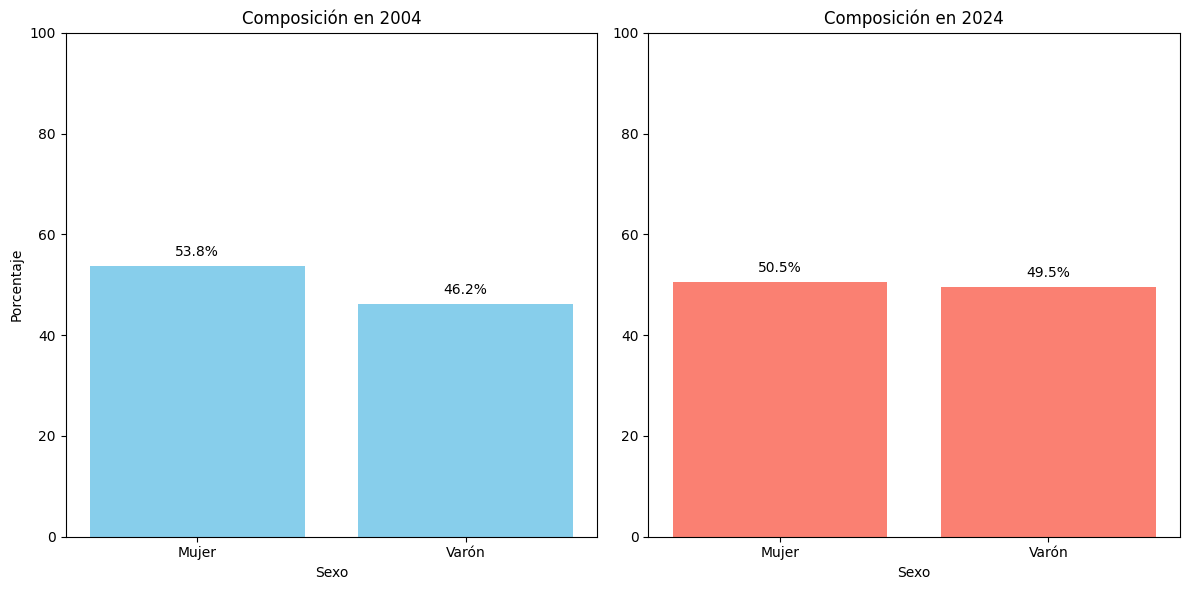

In [103]:
composicion_bar(bb_2004_counts, bb_2024_counts, 'Sexo')

### Matriz de correlación

In [11]:
columnas = ['ch04', 'ch06', 'ch07', 'ch08', 'nivel_ed', 'estado', 'cat_inac', 'ipcf']

In [32]:
# Sacamos esta función del link en la consigna
def heatmap(x, y, size):
    fig, ax = plt.subplots()
    
    x_labels = [v for v in sorted(x.unique())]
    y_labels = [v for v in sorted(y.unique())]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    
    size_scale = 500
    ax.scatter(
        x=x.map(x_to_num), 
        y=y.map(y_to_num), 
        s=size * size_scale,
        marker='s'
    )
    
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=90, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)

In [39]:
# Como la mayoría de las variables son catgóricas, para hacer las correlaciones tengo que conseguir las dummies
bb2004_dummies = pd.get_dummies(bb_2004[columnas], prefix= '', prefix_sep= '')

In [40]:
# Vamos a eliminar las columnas que tienen todo False
bb2004_dummies = bb2004_dummies.loc[:, (bb2004_dummies != 0).any(axis=0)]

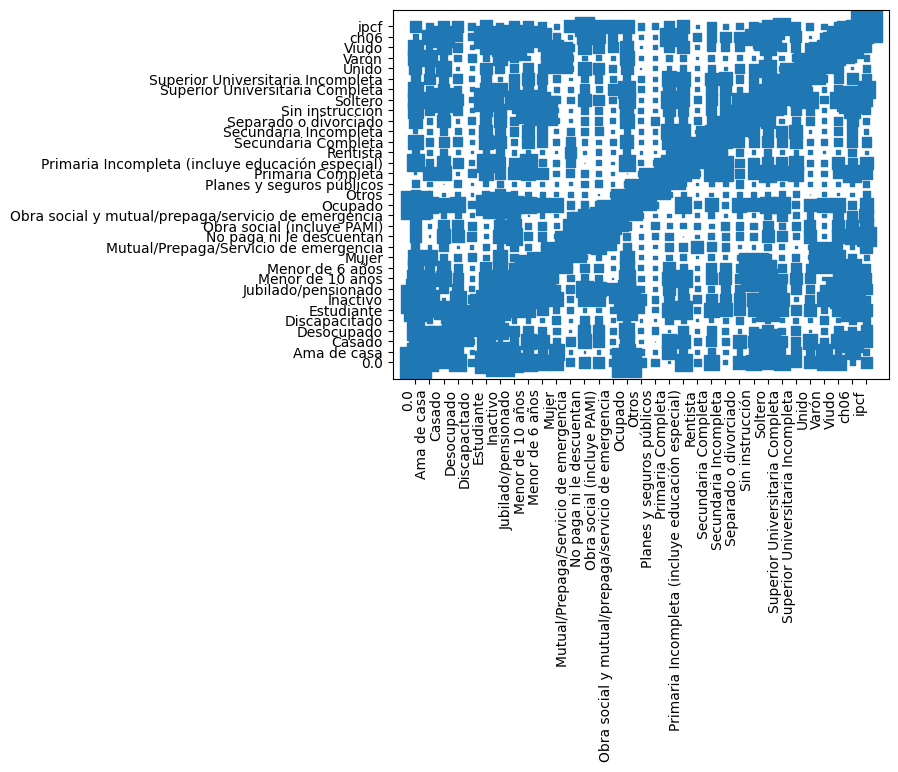

In [41]:
corr = bb2004_dummies.corr() # Saco la correlación
corr = pd.melt(corr.reset_index(), id_vars='index') # Lo transforma en un df de tres columnas
corr.columns = ['x', 'y', 'value'] # Le cambio el nombre a las columnas

heatmap(
    x=corr['x'],
    y=corr['y'],
    size=corr['value'].abs()
)

In [34]:
# A las categorías que nos interesan les ponemos los verdaderos valores
bb_2024['estado'] = bb_2024['estado'].cat.rename_categories({'0': "Entrevista Individual No Realizada", '1': "Ocupado", '2': 'Desocupado', '3':'Inactivo', '4': 'Menor de 10 años'})
bb_2024['cat_inac'] = bb_2024['cat_inac'].cat.rename_categories({'1': "Jubilado/Pensionado", '2': "Rentista", '3': 'Estudiante', '4':'Ama de Casa', '5': 'Menor de 6 años', '6': 'Discapacitado', '7': 'Otros'})
bb_2024['nivel_ed'] = bb_2024['nivel_ed'].cat.rename_categories({'1': "Primario Incompleto", '2': "Primario Completo", '3': 'Secundario Incompleto', '4':'Secundario Completo', '5': 'Superior Universitario Incompleto', '6': 'Superior Universitario Completo', '7': 'Sin Instrucción', '8': 'Ns/Nr'})
bb_2024['ch07'] = bb_2024['ch07'].cat.rename_categories({'1': "Unido", '2': "Casado", '3': 'Separado/Divorciado', '4':'Viudo', '5': 'Soltero'})
bb_2024['ch08'] = bb_2024['ch08'].cat.rename_categories({'1': "Obra Social (incluye PAMI)", '2': "Mutual/Prepaga/Servicio de Emergencia", '3': 'Planes y Seguros Públicos', '4':'No Pagan ni le Descuentan', '9': 'Ns/Nr', '12': 'Obra Social y Mutual/Prepaga/Servicio de Emegencia', '13': 'Obra Social y Planes y Seguros Públicos', '23': 'Mutual/Prepaga/Servicio de Emergencia y Seguros Públicos', '123': 'Obra Social, Mutual/Prepaga/Servicio de Emergencia y Planes y Seguros Públicos'})

# Armamos el df con las dummies
bb2024_dummies = pd.get_dummies(bb_2024[columnas], prefix= '', prefix_sep= '')

In [35]:
# También eliminamos las columnas con todo False
bb2024_dummies = bb2024_dummies.loc[:, (bb2024_dummies != 0).any(axis=0)]

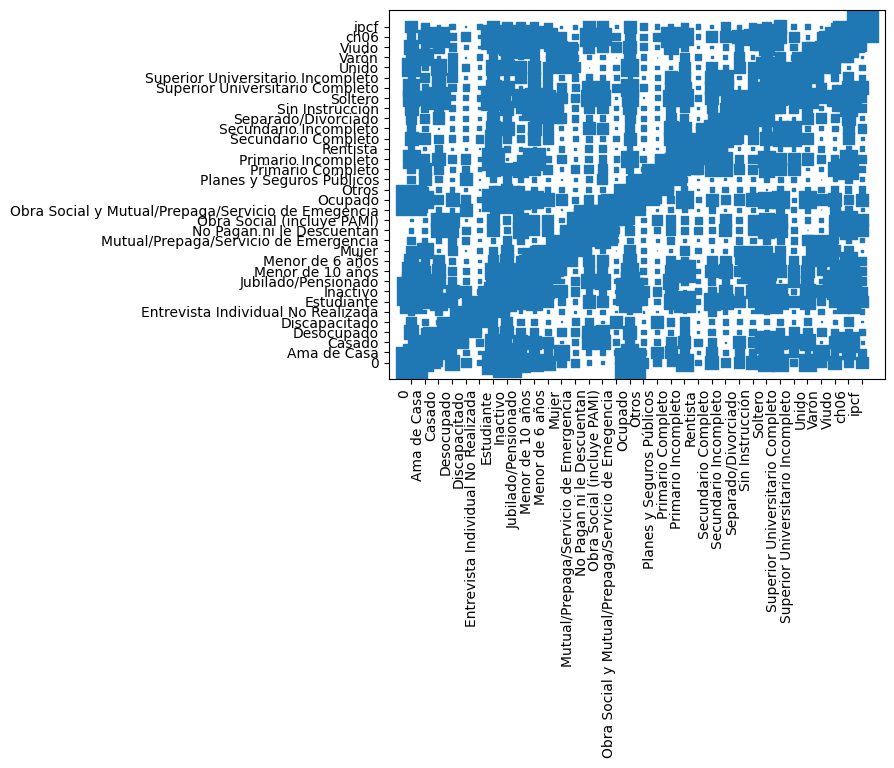

In [36]:
corr = bb2024_dummies.corr()
corr = pd.melt(corr.reset_index(), id_vars='index')
corr.columns = ['x', 'y', 'value']
heatmap(
    x=corr['x'],
    y=corr['y'],
    size=corr['value'].abs()
)

### Desocupados, Inactivos y Ocupados

In [113]:
agregacion_2004 = bb2004_dummies.groupby(['Desocupado', 'Inactivo', 'Ocupado']).agg(count=('ipcf', 'size'),mean_ipcf=('ipcf', 'mean'))
agregacion_2004.index = ['Otros', 'Ocupados', 'Inactivos', 'Desocupados']
print(agregacion_2004)

             count   mean_ipcf
Otros          117  246.184432
Ocupados       440  399.765731
Inactivos      494  315.702988
Desocupados     91  206.938540


In [114]:
agregacion_2024 = bb2024_dummies.groupby(['Desocupado', 'Inactivo', 'Ocupado']).agg(count=('ipcf', 'size'),mean_ipcf=('ipcf', 'mean'))
agregacion_2024.index = ['Otros', 'Ocupados', 'Inactivos', 'Desocupados']
print(agregacion_2024)

             count      mean_ipcf
Otros          103   95968.169223
Ocupados       432  169874.557847
Inactivos      425  117397.605247
Desocupados     38  105006.578947


In [115]:
respondieron_2004 = bb_2004.loc[bb_2004['estado'] != 'Entrevista individual no realizada (no respuesta al cuestion']
norespondieron_2004 = bb_2004.loc[bb_2004['estado'] == 'Entrevista individual no realizada (no respuesta al cuestion']

In [116]:
respondieron_2024 = bb_2024.loc[bb_2024['estado'] != 'Entrevista Individual No Realizada']
norespondieron_2024 = bb_2024.loc[bb_2024['estado'] == 'Entrevista Individual No Realizada']

Al parecer en Bahía Blanca hay una única persona que no respondió para "estado"

### Composición PEA

In [126]:
respondieron_2004['pea'] = np.where(respondieron_2004['estado'].isin(['Ocupado', 'Desocupado']), 1, 0)
respondieron_2004['pea'] = respondieron_2004['pea'].astype('category')

respondieron_2024.loc[:,'pea'] = np.where(respondieron_2024['estado'].isin(['Ocupado', 'Desocupado']), 1, 0)
respondieron_2024.loc[:,'pea'] = respondieron_2024['pea'].astype('category')

In [118]:
respondieron_2004_counts = respondieron_2004['pea'].value_counts(normalize=True) * 100
respondieron_2024_counts = respondieron_2024['pea'].value_counts(normalize=True) * 100

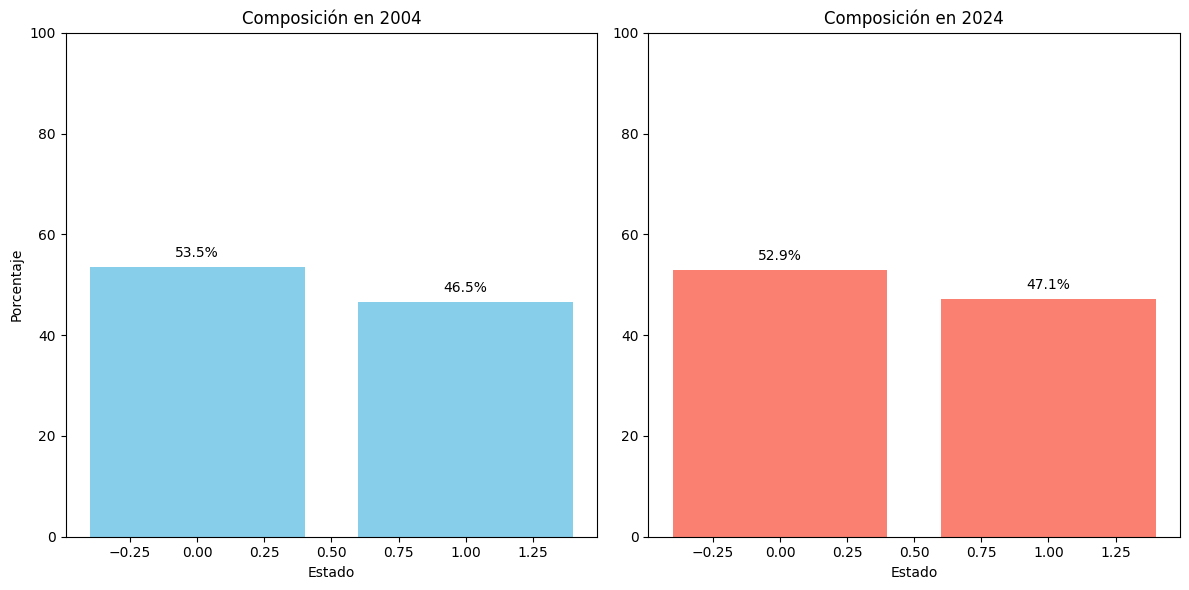

In [119]:
composicion_bar(respondieron_2004_counts, respondieron_2024_counts, 'Estado')

### Composición PET

In [151]:
respondieron_2004['pet'] = np.where((respondieron_2004['ch06'] > 15) & (respondieron_2004['ch06'] < 65), 1, 0)
respondieron_2004['pet'] = respondieron_2004['pet'].astype('category')

respondieron_2024.loc[:,'pet'] = np.where((respondieron_2024['ch06'] > 15) & (respondieron_2024['ch06'] < 65), 1, 0)
respondieron_2024.loc[:,'pet'] = respondieron_2024['pet'].astype('category')

In [121]:
respondieron_2004_counts = respondieron_2004['pet'].value_counts(normalize=True) * 100
respondieron_2024_counts = respondieron_2024['pet'].value_counts(normalize=True) * 100

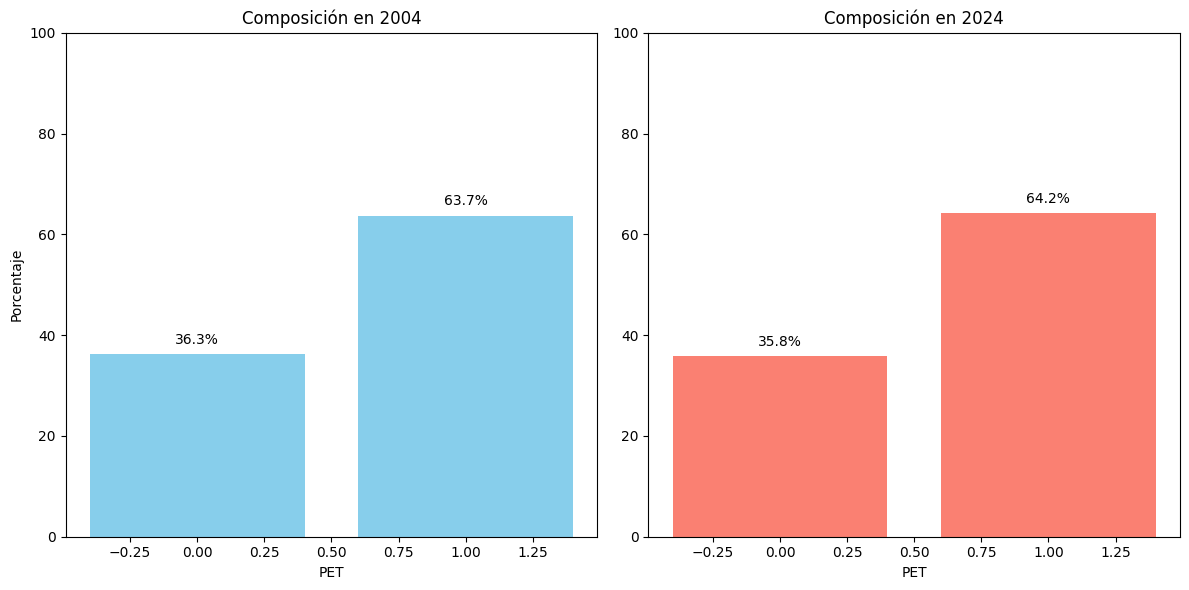

In [122]:
composicion_bar(respondieron_2004_counts, respondieron_2024_counts, 'PET')

### Desocupados

In [124]:
respondieron_2004['desocupada'] = np.where(respondieron_2004['estado'].isin(['Desocupado']), 1, 0)
respondieron_2004['desocupada'] = respondieron_2004['desocupada'].astype('category')

respondieron_2024.loc[:,'desocupada'] = np.where(respondieron_2024['estado'].isin(['Desocupado']), 1, 0)
respondieron_2024.loc[:,'desocupada'] = respondieron_2024['desocupada'].astype('category')

In [148]:
agg_desocup_2004 = respondieron_2004.loc[respondieron_2004['desocupada'] == 1].groupby(['nivel_ed'], observed=True).agg(count=('desocupada', 'count'))
agg_desocup_2004['proporcion'] = agg_desocup_2004['count'] / agg_desocup_2004['count'].sum()
print(agg_desocup_2004)

                                                  count  proporcion
nivel_ed                                                           
Primaria Completa                                    21    0.230769
Primaria Incompleta (incluye educación especial)      4    0.043956
Secundaria Completa                                  22    0.241758
Secundaria Incompleta                                20    0.219780
Superior Universitaria Completa                       3    0.032967
Superior Universitaria Incompleta                    21    0.230769


In [153]:
agg_desocup_2024 = respondieron_2024.loc[respondieron_2024['desocupada'] == 1].groupby(['nivel_ed'], observed=True).agg(count=('desocupada', 'count'))
agg_desocup_2024['proporcion'] = agg_desocup_2024['count'] / agg_desocup_2024['count'].sum()
print(agg_desocup_2024)

                                   count  proporcion
nivel_ed                                            
Primario Completo                      3    0.078947
Secundario Incompleto                 10    0.263158
Secundario Completo                   11    0.289474
Superior Universitario Incompleto     12    0.315789
Superior Universitario Completo        2    0.052632


In [137]:
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100] 
labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-99']

respondieron_2004['edad_categoria'] = pd.cut(respondieron_2004['ch06'], bins=bins, labels=labels, right=False)
respondieron_2024.loc[:,'edad_categoria'] = pd.cut(respondieron_2024['ch06'], bins=bins, labels=labels, right=False)

In [154]:
agg_desocup_2004 = respondieron_2004.loc[respondieron_2004['desocupada'] == 1].groupby(['edad_categoria'], observed=True).agg(count=('desocupada', 'size'))
agg_desocup_2004['proporcion'] = agg_desocup_2004['count'] / agg_desocup_2004['count'].sum()
print(agg_desocup_2004)

                count  proporcion
edad_categoria                   
10-19              13    0.142857
20-29              41    0.450549
30-39              11    0.120879
40-49              12    0.131868
50-59               5    0.054945
60-69               8    0.087912
70-79               1    0.010989


In [155]:
agg_desocup_2024 = respondieron_2024.loc[respondieron_2024['desocupada'] == 1].groupby(['edad_categoria'], observed=True).agg(count=('desocupada', 'size'))
agg_desocup_2024['proporcion'] = agg_desocup_2024['count'] / agg_desocup_2024['count'].sum()
print(agg_desocup_2024)

                count  proporcion
edad_categoria                   
10-19               3    0.078947
20-29              16    0.421053
30-39               9    0.236842
40-49               7    0.184211
50-59               2    0.052632
60-69               1    0.026316


# Clasificación

In [170]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score

In [173]:
y_2004 = respondieron_2004['desocupada']
y_2024 = respondieron_2024['desocupada']

x_2004 = pd.get_dummies(respondieron_2004[columnas])
x_2024 = pd.get_dummies(respondieron_2024[columnas])

In [174]:
x_2004['constante'] = 1
x_2024.loc[:,'constante'] = 1

In [175]:
x_train_2004, x_test_2004, y_train_2004, y_test_2004 = train_test_split(x_2004, y_2004, test_size = 0.3, random_state = 101)
x_train_2024, x_test_2024, y_train_2024, y_test_2024 = train_test_split(x_2024, y_2024, test_size = 0.3, random_state = 101)

In [176]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    cm = confusion_matrix(y_test, y_pred)
    
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    
    accuracy = accuracy_score(y_test, y_pred)
    
    return cm, fpr, tpr, auc, accuracy

In [192]:
models = {
    'Regresión Logística': LogisticRegression(max_iter= 10000),
    'Análisis Discriminante Lineal': LinearDiscriminantAnalysis(),
    'KNN (k=3)': KNeighborsClassifier(n_neighbors=3),
    'Naive Bayes': GaussianNB()
}

## 2004

In [193]:
results = {}
print("Resultados para 2004:")
for model_name, model in models.items():
    cm, fpr, tpr, auc, accuracy = evaluate_model(model, x_train_2004, x_test_2004, y_train_2004, y_test_2004)
    results[model_name] = {
        'Matriz de Confusión': cm,
        'AUC': auc,
        'Accuracy': accuracy,
        'FPR': fpr,
        'TPR': tpr
    }

    print(f"{model_name}:")
    print(f"Matriz de Confusión:\n{cm}")
    print(f"AUC: {auc:.2f}")
    print(f"Accuracy: {accuracy:.2f}\n")


Resultados para 2004:


Regresión Logística:
Matriz de Confusión:
[[312   0]
 [  0  31]]
AUC: 1.00
Accuracy: 1.00

Análisis Discriminante Lineal:
Matriz de Confusión:
[[301  11]
 [ 26   5]]
AUC: 0.81
Accuracy: 0.89

KNN (k=3):
Matriz de Confusión:
[[303   9]
 [ 27   4]]
AUC: 0.63
Accuracy: 0.90

Naive Bayes:
Matriz de Confusión:
[[312   0]
 [  0  31]]
AUC: 1.00
Accuracy: 1.00



### Curva ROC

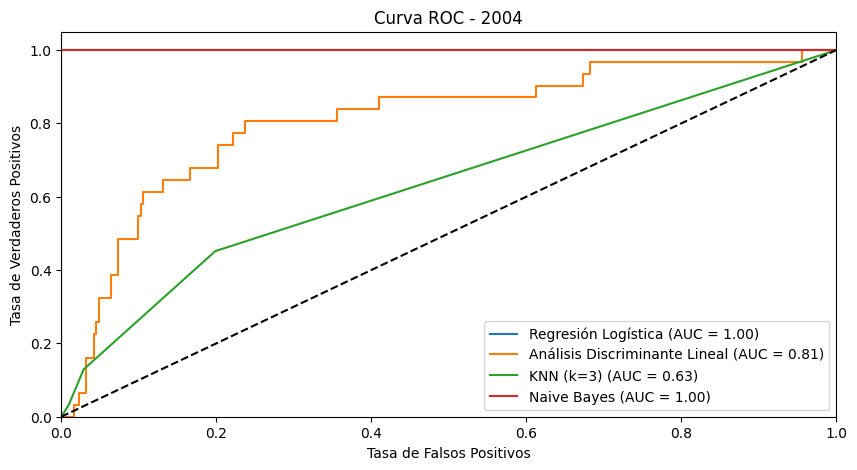

In [194]:
plt.figure(figsize=(10, 5))
for model_name, metrics in results.items():
    plt.plot(metrics['FPR'], metrics['TPR'], label=f'{model_name} (AUC = {metrics["AUC"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC - 2004')
plt.legend(loc='lower right')
plt.show()

### 2024

In [195]:
results.clear() # Limpiamos el diccionario con los resultados del 2004
print("Resultados para 2024:")
for model_name, model in models.items():
    cm, fpr, tpr, auc, accuracy = evaluate_model(model, x_train_2024, x_test_2024, y_train_2024, y_test_2024)
    results[model_name] = {
        'Matriz de Confusión': cm,
        'AUC': auc,
        'Accuracy': accuracy,
        'FPR': fpr,
        'TPR': tpr
    }

    print(f"{model_name}:")
    print(f"Matriz de Confusión:\n{cm}")
    print(f"AUC: {auc:.2f}")
    print(f"Accuracy: {accuracy:.2f}\n")

Resultados para 2024:
Regresión Logística:
Matriz de Confusión:
[[290   0]
 [  1   9]]
AUC: 1.00
Accuracy: 1.00

Análisis Discriminante Lineal:
Matriz de Confusión:
[[289   1]
 [ 10   0]]
AUC: 0.81
Accuracy: 0.96

KNN (k=3):
Matriz de Confusión:
[[286   4]
 [ 10   0]]
AUC: 0.55
Accuracy: 0.95

Naive Bayes:
Matriz de Confusión:
[[290   0]
 [ 10   0]]
AUC: 0.71
Accuracy: 0.97



### Curva ROC

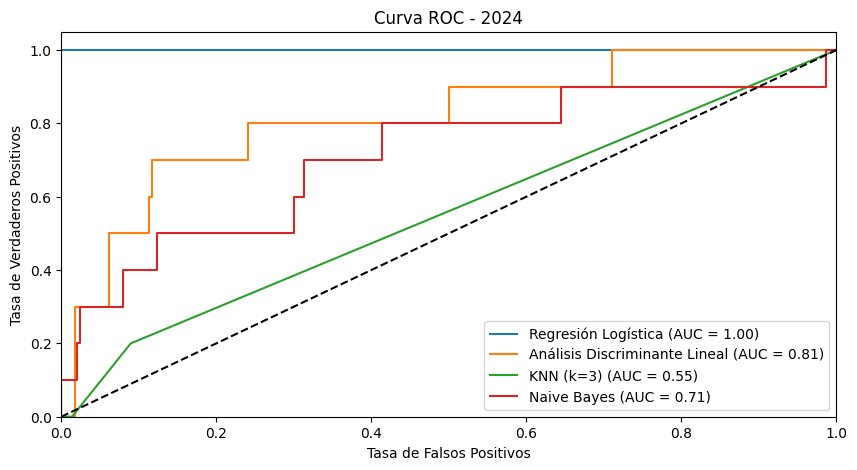

In [196]:
plt.figure(figsize=(10, 5))
for model_name, metrics in results.items():
    plt.plot(metrics['FPR'], metrics['TPR'], label=f'{model_name} (AUC = {metrics["AUC"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC - 2024')
plt.legend(loc='lower right')
plt.show()

## Conclusiones

Para este problema, el modelo logístico y el naive bayes parecen ser los que mejor predicen fuera de la muestra, ya que muestran el mejor accuracy y AUC. Son tan buenos que en 2004 ni siquiera tienen falsos positivos ni negativos. En 2024 les cuesta un poco más, pero en términos generales predicen muy bien

## Predecir en No Respondieron

Tenemos una única observación para norespondieron

In [189]:
norespondieron_dummies = pd.get_dummies(norespondieron_2024[columnas])
norespondieron_dummies.loc[:, 'constante'] = 1

Elegimos el modelo logístico de 2024 para predecir el valor de esta observación, ya que es el que menos falsos positivos o negativos tiene dentro de los modelos de 2024

In [191]:
lr = LogisticRegression(max_iter= 10000)
lr.fit(x_train_2024, y_train_2024)
    
y_pred = lr.predict(norespondieron_dummies)
print(y_pred)

[0]


Predice que no va a estar desocupada esta persona